# Demo Similarity

**Base Model**

* era5

**CMIP5 Models**:
* "inmcm4",
* "access1_0",
* "bcc_csm1_1",
* "bcc_csm1_1_m",
* "bnu_esm",
* "cnrm_cm5",
* "ec_earth",
* "fgoals_s2",
* "ipsl_cm5b_lr",
* "mpi_esm_lr",
* "mpi_esm_mr"

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
isp_root = "/home/emmanuel/code/isp_data"
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))
sys.path.append(str(isp_root))

from pathlib import Path

#
import xarray as xr
from pprint import pprint
import cftime
import xesmf as xe
from isp_data.esdc.temporal import convert_to_360day_monthly
from src.models.univariate import pearson
from src.models.kernels import rv_coefficient, cka_coefficient
import tqdm
import numpy as np
import pandas as pd
import itertools

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
ERA5_DIR = "/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/ERA5/REANALYSIS/ZARR"
CMIP5_DIR = "/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF"
VARIABLE = "mean_sea_level_pressure"
TIME_SLICE = slice("2020", "2020")
BASE_GRID_MODEL = "ipsl_cm5b_lr"


In [3]:
d_ = xr.open_zarr("/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/ERA5/REANALYSIS/ZARR/mean_sea_level_pressure/era5_reanalysis.nc")

In [4]:
!ls $ERA5_DIR

mean_sea_level_pressure


In [5]:

cmip_glob = Path(CMIP5_DIR).joinpath(VARIABLE).glob(f"*.nc")
era5_glob = Path(ERA5_DIR).joinpath(VARIABLE).glob(f"*.nc")
nc_files = [str(x) for x in cmip_glob if x.is_dir()]
nc_files = nc_files + [str(x) for x in era5_glob if x.is_dir()]

In [6]:
nc_files

['/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF/mean_sea_level_pressure/giss_e2_h_cc_rcp8_5.nc',
 '/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF/mean_sea_level_pressure/mpi_esm_lr_rcp8_5.nc',
 '/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF/mean_sea_level_pressure/bnu_esm_rcp8_5.nc',
 '/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF/mean_sea_level_pressure/access1_0_rcp8_5.nc',
 '/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF/mean_sea_level_pressure/access1_3_rcp8_5.nc',
 '/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF/mean_sea_level_pressure/noresm1_m_rcp8_5.nc',
 '/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF/mean_sea_level_pressure/mpi_esm_mr_rcp8_5.nc',
 '/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/

In [7]:
ds = {}
for ifile in nc_files:
    # manually set the encoding to use cftime

    i_ds = xr.open_zarr(ifile, decode_times=True, use_cftime=True)

    # assign a new coordinate name
    try:
        model_id = i_ds.model_id.lower().replace("-", "_")

    except:
        model_id = "era5"
        i_ds = i_ds.rename({"msl": "psl", "latitude": "lat", "longitude": "lon"})
    i_ds = i_ds.assign_coords({"model_id": model_id})
    # create the same calendar
    i_ds = convert_to_360day_monthly(i_ds, False)

    # move attributes to new coordinate
    i_ds.model_id.attrs = i_ds.attrs
    i_ds.attrs = {}

    ds[model_id] = i_ds

In [8]:
# =====================
# Select Time Slice
# =====================
with tqdm.tqdm(ds.items()) as pbar:
    for imodel_id, ids in pbar:
        
        pbar.set_description(f"Model: {model_id}")

        ds[imodel_id] = ds[imodel_id].sel(time=TIME_SLICE)

n_time = ds[imodel_id]["time"].values.shape[0]

Model: era5: 100%|██████████| 13/13 [00:00<00:00, 163.27it/s]


In [9]:
# =====================
# REGRID
# =====================
ds_out = xr.Dataset(
    {
        "lat": (["lat"], ds[BASE_GRID_MODEL].lat),
        "lon": (["lon"], ds[BASE_GRID_MODEL].lon),
    }
)

n_lat = ds_out.coords["lat"].values.shape[0]
n_lon = ds_out.coords["lon"].values.shape[0]

final_ds = []

for imodel_id, ids in ds.items():
#     if imodel_id == "ipsl_cm5b_lr":
#         t = ids.psl
#         t.attrs = ids.attrs
#         final_ds.append(t)
#         continue

    regridder = xe.Regridder(ids, ds_out, "nearest_s2d")
    t = regridder(ids["psl"].compute())
    t.attrs = ids.attrs
    final_ds.append(t)

final_ds = xr.concat(final_ds, dim="model_id").reset_coords()

/home/emmanuel/.conda/envs/isp_data/lib/python3.9/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/home/emmanuel/.conda/envs/isp_data/lib/python3.9/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/home/emmanuel/.conda/envs/isp_data/lib/python3.9/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/home/emmanuel/.conda/envs/isp_data/lib/python3.9/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parame

In [10]:
final_ds.coords["model_id"].values

array(['giss_e2_h_cc', 'mpi_esm_lr', 'bnu_esm', 'access1_0', 'access1_3',
       'noresm1_m', 'mpi_esm_mr', 'ipsl_cm5b_lr', 'ipsl_cm5a_mr',
       'inmcm4', 'fio_esm', 'ipsl_cm5a_lr', 'era5'], dtype='<U12')

In [11]:
from src.models.km.hsic import cka_coefficient
from src.models.km.rv import rv_coefficient
from src.models.km.rhsic import cka_coefficient_nystroem, cka_coefficient_rff
from src.models.univariate import pearson, pearson_dim, univariate_stats
from src.models.multivariate import multivariate_stats
import itertools

In [84]:
knn_entropy(np.hstack([X, Y]), 5, n_jobs=-1)

/home/emmanuel/projects/rbig4eo/src/models/information/knn.py:28: RuntimeWarning: divide by zero encountered in true_divide
  + np.log(vol)


-inf

In [85]:
np.hstack([X, Y]).shape, np.vstack([X, Y]).shape

((9216, 24), (18432, 12))

In [45]:
X_ = np.ones((100, 10))
X_.ravel()[:, None].shape

(1000, 1)

In [80]:
knn_entropy(np.vstack([X, Y]), 2, n_jobs=-1)

63.553461176557825

In [15]:
EXPERIMENT = "multivariate"

In [81]:
x.shape, y.shape

((9216, 12), (9216, 12))

In [12]:
from src.models.information.mutual_information import RBIGEstimator

NameError: name 'x' is not defined

In [16]:
# =====================
# PEARSON CORRELATION
# =====================

import pandas as pd


from scipy.stats import pearsonr

# get all model IDS


import tqdm
import numpy as np


all_stats = pd.DataFrame()
model_ids = final_ds.coords["model_id"].values
sym_pairs = [pair for pair in itertools.combinations(model_ids, 2)]

with tqdm.tqdm(sym_pairs) as pbar:

    for i, imodel_pair in enumerate(pbar):
        
        imodel_stats = {"model_0": imodel_pair[0], "model_1": imodel_pair[1]}

        pbar.set_description(f"Model 1: {imodel_pair[0]}, Model 2: {imodel_pair[1]}")

        # select model
        ids = final_ds.sel(model_id=[imodel_pair[0], imodel_pair[1]]).psl.values


        # calculate pearson correlation
#         pbar.set_description(f"Calculating Correlation...")
        
#         x = np.reshape(ids[0], (n_lat * n_lon * n_time))
#         y = np.reshape(ids[1], (n_lat * n_lon * n_time))
        
        if EXPERIMENT == "univariate":

            # calculate pearson correlation
            pbar.set_description(f"Calculating Univariate Stats...")

            x = np.reshape(ids[0], (n_lat * n_lon * n_time))
            y = np.reshape(ids[1], (n_lat * n_lon * n_time))

            uni_stats = univariate_stats(x, y)
            
            imodel_stats = {**imodel_stats, **uni_stats}
            
        elif EXPERIMENT == "multivariate":

            # calculate pearson correlation
            pbar.set_description(f"Calculating Multivariate Stats...")

            x = np.reshape(ids[0], (n_lat * n_lon, n_time))
            y = np.reshape(ids[1], (n_lat * n_lon, n_time))

            multi_stats = multivariate_stats(x, y)
            
            imodel_stats = {**imodel_stats, **multi_stats}
            
#         prs_r = pearson(x, y)
        
#         imodel_stats = {**imodel_stats, **prs_r}
        
        
#         X = np.reshape(ids[0], (n_lat * n_lon, n_time))
#         Y = np.reshape(ids[1], (n_lat * n_lon, n_time))
        
#         # calculate pearson correlation
#         pbar.set_description(f"Calculating Pearson (per dim)...")

#         prs_d_r = pearson_dim(X, Y)
        
#         imodel_stats = {**imodel_stats, **prs_d_r}
        
#         # calculate pearson correlation
#         pbar.set_description(f"Calculating RV Coeff ...")
        
#         X = np.reshape(ids[0], (n_lat * n_lon, n_time))
#         Y = np.reshape(ids[1], (n_lat * n_lon, n_time))
#         rv = rv_coefficient(X, Y)
        
#         imodel_stats = {**imodel_stats, **rv}
        
        
#         # calculate pearson correlation
#         pbar.set_description(f"Calculating nHSIC Coeff...")
        
#         nhsic = cka_coefficient(X, Y)
        
#         imodel_stats = {**imodel_stats, **nhsic}
                
#         # calculate cka (nystrom)
#         pbar.set_description(f"Calculating rand nHSIC (nystroem) Coeff...")
        
#         rhsic_nys = cka_coefficient_nystroem(X, Y, )
        
#         imodel_stats = {**imodel_stats, **rhsic_nys}
        
#         # calculate cka (rff)
#         pbar.set_description(f"Calculating rand nHSIC (rff) Coeff...")
        
#         rhsic_rff = cka_coefficient_rff(X, Y)
        
#         imodel_stats = {**imodel_stats, **rhsic_rff}
        
        
        all_stats = pd.concat([all_stats, pd.DataFrame(imodel_stats, index=[i])], axis=0)
        break

Calculating Multivariate Stats...:   0%|          | 0/78 [00:17<?, ?it/s]         


In [ ]:
%%time
mi_clf = RBIGEstimator().fit(x, y)

In [68]:
all_stats

,model_0,model_1,pearson_d,pearson__dtime,x_std_d,y_std_d,rv_coef,rv_xy_norm,rv_x_norm,rv_y_norm,...,rcka_coeff_nys,rcka_xy_norm_nys,rcka_x_norm_nys,rcka_y_norm_nys,rcka_nys_time,rcka_coeff_rff,rcka_xy_norm_rff,rcka_x_norm_rff,rcka_y_norm_rff,rcka_time_rff
0,giss_e2_h_cc,mpi_esm_lr,0.797626,0.010391,981.968832,966.831601,0.664706,7.746479e+13,1.096883e+07,1.062465e+07,...,0.432565,0.028782,0.257932,0.257969,0.390771,0.431984,0.031703,0.246554,0.297657,0.450588


In [69]:
from src.visualization.climate.utils import get_pivot_df

In [71]:
df_ = get_pivot_df(all_stats, "pearson_d")
df_

model_1,giss_e2_h_cc,mpi_esm_lr
model_0,,
giss_e2_h_cc,NaN,0.797626
mpi_esm_lr,0.797626,NaN


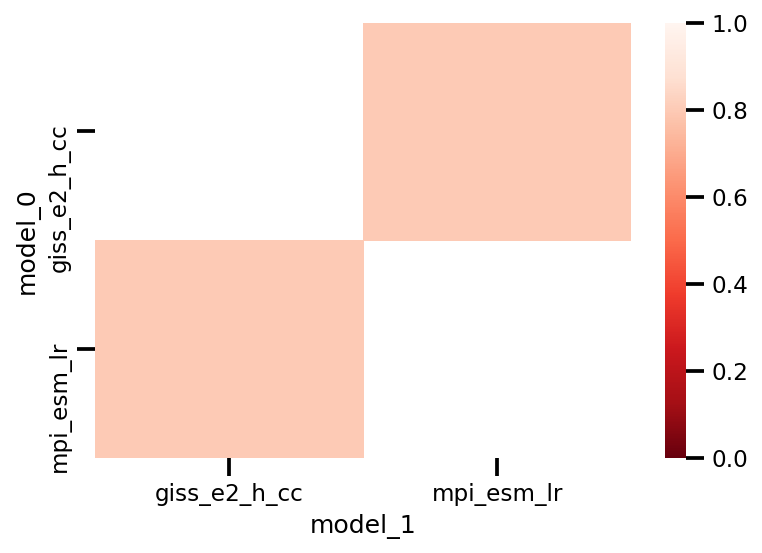

In [72]:
# t = all_stats[["model_0", "model_1", "pearson"]]
# t = pd.concat([t, t.rename(columns={"model_0": "model_1", "model_1": "model_0"})], axis=0).drop_duplicates()
# t = t.pivot("model_0", "model_1", "pearson")

ax = sns.heatmap(df_, vmin=0, vmax=1.0, cmap='Reds_r')

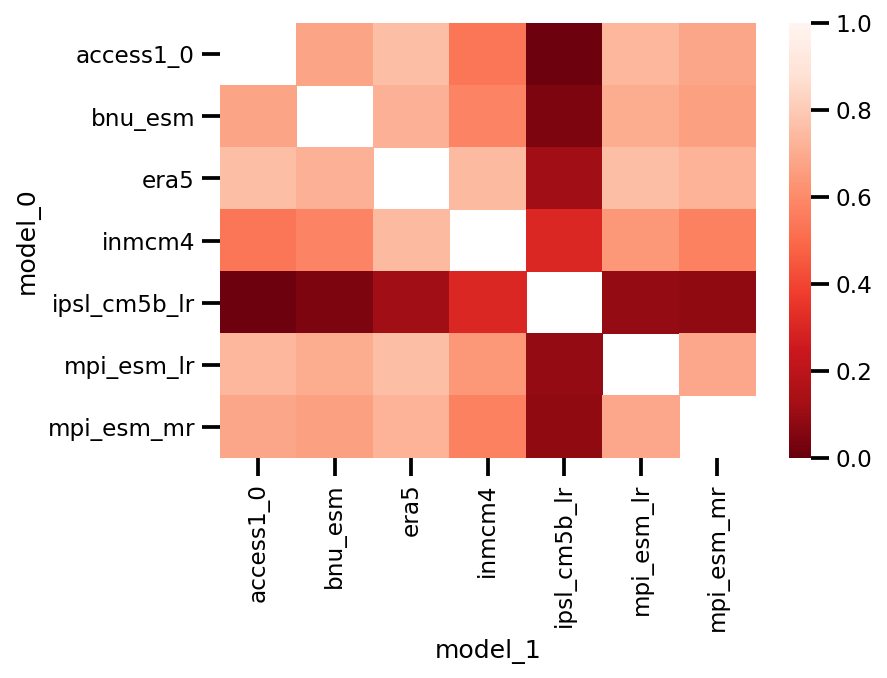

In [36]:
t = all_stats[["model_0", "model_1", "rv_coef"]]
t = pd.concat([t, t.rename(columns={"model_0": "model_1", "model_1": "model_0"})], axis=0).drop_duplicates()
t = t.pivot("model_0", "model_1", "rv_coef")

ax = sns.heatmap(t, vmin=0, vmax=1.0, cmap='Reds_r')

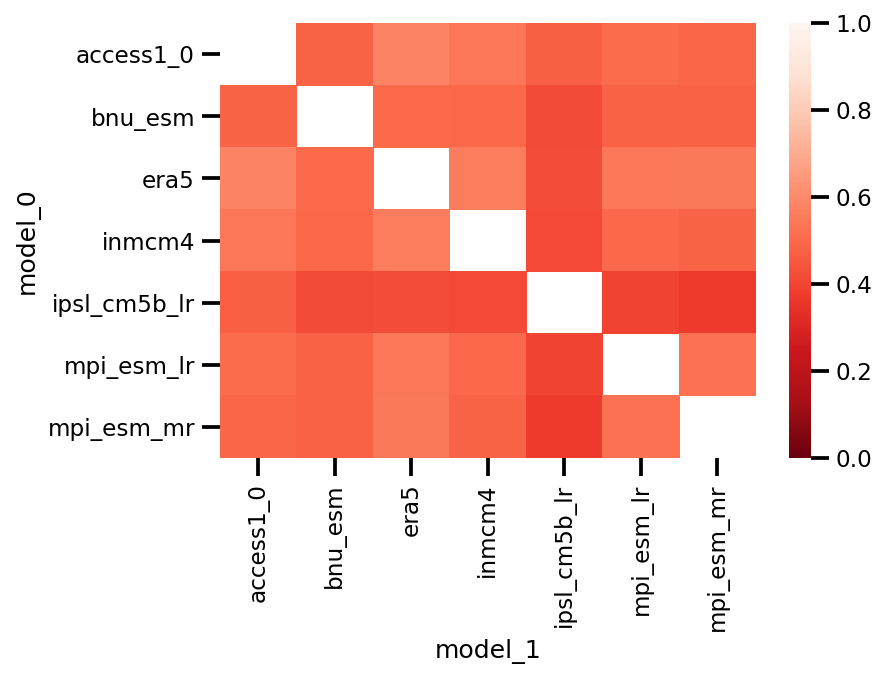

In [37]:
t = all_stats[["model_0", "model_1", "cka_coeff"]]
t = pd.concat([t, t.rename(columns={"model_0": "model_1", "model_1": "model_0"})], axis=0).drop_duplicates()
t = t.pivot("model_0", "model_1", "cka_coeff")

ax = sns.heatmap(t, vmin=0, vmax=1.0, cmap='Reds_r')

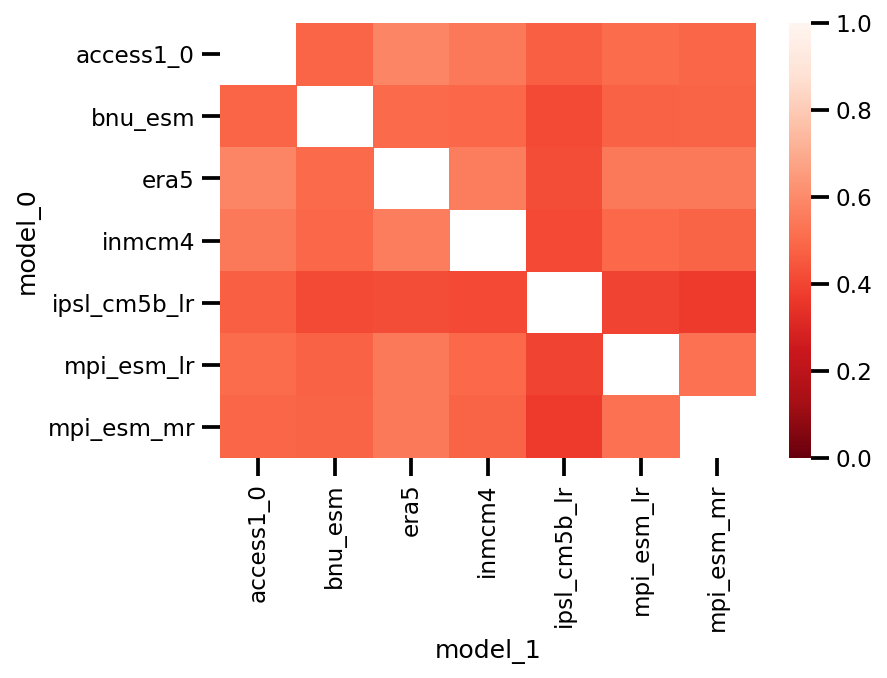

In [38]:
t = all_stats[["model_0", "model_1", "rcka_coeff_nys"]]
t = pd.concat([t, t.rename(columns={"model_0": "model_1", "model_1": "model_0"})], axis=0).drop_duplicates()
t = t.pivot("model_0", "model_1", "rcka_coeff_nys")

ax = sns.heatmap(t, vmin=0, vmax=1.0, cmap='Reds_r')

In [76]:
import scipy.cluster.hierarchy as spc
pdist = 1 - np.abs(df_.values)
pdist = pdist[np.triu_indices_from(pdist, k=1)]
linkage = spc.linkage(pdist, method="complete", optimal_ordering=True)
order = spc.leaves_list(linkage)

name_corrections = {
    "access1_0": "ACCESS1.0",
    "bnu_esm": "BNU ESM",
    "era5": "ERA5",
    "inmcm4": "INMCM4",
    "ipsl_cm5b_lr": "IPSL-CM5B-LR",
    "mpi_esm_lr": "MPI-ESM-LR",
    "mpi_esm_mr": "MPI-ESM-MR",
}
names = [i for i in name_corrections.values()]
# def names(i):
#     return name_corrections

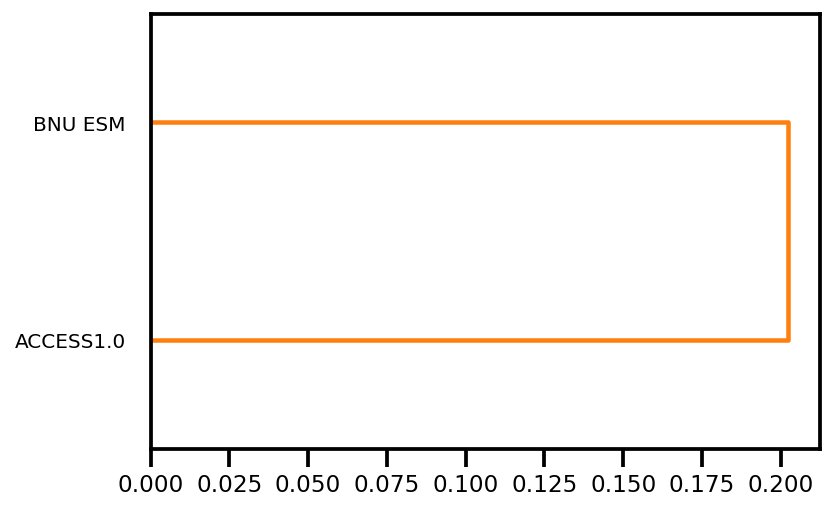

In [80]:
fig, ax = plt.subplots()
d = spc.dendrogram(
        linkage,
        above_threshold_color="k",
        color_threshold=0.4,
        orientation="right",
        leaf_label_func=lambda i: names[i],
        leaf_font_size=10,
        leaf_rotation=0,
    ax=ax
    )
plt.show()

In [ ]:
all_pairs = [pair for pair in itertools.product(model_ids, model_ids)]

grid_size =

for im, jm in all_pairs

In [ ]:
from src.models.univariate import univariate_stats, pearson
from src.models.kernels import rv_coefficient, cka_coefficient

In [47]:
model_ids

array(['inmcm4', 'bnu_esm', 'ipsl_cm5b_lr', 'mpi_esm_mr', 'access1_0',
       'mpi_esm_lr', 'era5'], dtype='<U12')

In [61]:
[pair for pair in itertools.product(model_ids, model_ids)]

[('giss_e2_h_cc', 'giss_e2_h_cc'),
 ('giss_e2_h_cc', 'mpi_esm_lr'),
 ('giss_e2_h_cc', 'bnu_esm'),
 ('giss_e2_h_cc', 'access1_0'),
 ('giss_e2_h_cc', 'access1_3'),
 ('giss_e2_h_cc', 'noresm1_m'),
 ('giss_e2_h_cc', 'mpi_esm_mr'),
 ('giss_e2_h_cc', 'ipsl_cm5b_lr'),
 ('giss_e2_h_cc', 'ccsm4'),
 ('giss_e2_h_cc', 'ipsl_cm5a_mr'),
 ('giss_e2_h_cc', 'inmcm4'),
 ('giss_e2_h_cc', 'fio_esm'),
 ('giss_e2_h_cc', 'ipsl_cm5a_lr'),
 ('giss_e2_h_cc', 'era5'),
 ('mpi_esm_lr', 'giss_e2_h_cc'),
 ('mpi_esm_lr', 'mpi_esm_lr'),
 ('mpi_esm_lr', 'bnu_esm'),
 ('mpi_esm_lr', 'access1_0'),
 ('mpi_esm_lr', 'access1_3'),
 ('mpi_esm_lr', 'noresm1_m'),
 ('mpi_esm_lr', 'mpi_esm_mr'),
 ('mpi_esm_lr', 'ipsl_cm5b_lr'),
 ('mpi_esm_lr', 'ccsm4'),
 ('mpi_esm_lr', 'ipsl_cm5a_mr'),
 ('mpi_esm_lr', 'inmcm4'),
 ('mpi_esm_lr', 'fio_esm'),
 ('mpi_esm_lr', 'ipsl_cm5a_lr'),
 ('mpi_esm_lr', 'era5'),
 ('bnu_esm', 'giss_e2_h_cc'),
 ('bnu_esm', 'mpi_esm_lr'),
 ('bnu_esm', 'bnu_esm'),
 ('bnu_esm', 'access1_0'),
 ('bnu_esm', 'access1_3'),

In [90]:
import itertools
all_pairs = [pair for pair in itertools.product(model_ids, model_ids)]
inv_pairs = map(lambda x: tuple(reversed(x)), all_pairs)

all_pairs

[('inmcm4', 'inmcm4'),
 ('inmcm4', 'bnu_esm'),
 ('inmcm4', 'ipsl_cm5b_lr'),
 ('inmcm4', 'mpi_esm_mr'),
 ('inmcm4', 'access1_0'),
 ('inmcm4', 'mpi_esm_lr'),
 ('inmcm4', 'era5'),
 ('bnu_esm', 'inmcm4'),
 ('bnu_esm', 'bnu_esm'),
 ('bnu_esm', 'ipsl_cm5b_lr'),
 ('bnu_esm', 'mpi_esm_mr'),
 ('bnu_esm', 'access1_0'),
 ('bnu_esm', 'mpi_esm_lr'),
 ('bnu_esm', 'era5'),
 ('ipsl_cm5b_lr', 'inmcm4'),
 ('ipsl_cm5b_lr', 'bnu_esm'),
 ('ipsl_cm5b_lr', 'ipsl_cm5b_lr'),
 ('ipsl_cm5b_lr', 'mpi_esm_mr'),
 ('ipsl_cm5b_lr', 'access1_0'),
 ('ipsl_cm5b_lr', 'mpi_esm_lr'),
 ('ipsl_cm5b_lr', 'era5'),
 ('mpi_esm_mr', 'inmcm4'),
 ('mpi_esm_mr', 'bnu_esm'),
 ('mpi_esm_mr', 'ipsl_cm5b_lr'),
 ('mpi_esm_mr', 'mpi_esm_mr'),
 ('mpi_esm_mr', 'access1_0'),
 ('mpi_esm_mr', 'mpi_esm_lr'),
 ('mpi_esm_mr', 'era5'),
 ('access1_0', 'inmcm4'),
 ('access1_0', 'bnu_esm'),
 ('access1_0', 'ipsl_cm5b_lr'),
 ('access1_0', 'mpi_esm_mr'),
 ('access1_0', 'access1_0'),
 ('access1_0', 'mpi_esm_lr'),
 ('access1_0', 'era5'),
 ('mpi_esm_lr', '

In [73]:
len(all_pairs), len(sym_pairs)

(49, 21)

In [53]:
('era5', 'inmcm4') != tuple(reversed(('inmcm4', 'era5')))

False

In [52]:
reversed(('inmcm4', 'era5'))